In [1]:
from srn_data_collector.annotations_utils.data_model import (
    Base,
    BlobLvlAnnotations,
    BlobLvlAnnotationsModel,
    CompanyDetailsModel,
    CompanyDetailsTable,
    ComplianceItems,
    ComplianceItemsModel,
    DocumentInstances,
    DocumentInstancesModel,
    Indices,
    IndicesModel,
    ReportingRequirements,
    ReportingRequirementsModel,
    RptRequirementsMapping,
    RptRequirementsMappingModel,
    StandardsList,
    StandardsListModel,
    ValuesWithRevisions,
    ValuesWithRevisionsModel,
)

In [2]:
db_path = "/cluster/home/repo/my_llm_experiments/esrs_data_collection/srn_data_collector/main_nov26_bkp.db"

In [3]:
from sqlalchemy.orm import aliased
from sqlalchemy import create_engine, select, text
from sqlalchemy.orm import Session

# Assume you have an SQLAlchemy engine already created
engine = create_engine(f"sqlite:///{db_path}")

# Define the SQLAlchemy models
fvwr = aliased(ValuesWithRevisions)
dci = aliased(ComplianceItems)
drr = aliased(ReportingRequirements)
dcd = aliased(CompanyDetailsTable)
ddi = aliased(DocumentInstances)
dbla = aliased(BlobLvlAnnotations)
mrrsl = aliased(RptRequirementsMapping)
dsl = aliased(StandardsList)

# Build the SQLAlchemy query
stmt = select(
        fvwr.id.label('REVISION_ID'),
        dsl.family.label('STD_FAMILY'),
        dsl.name.label('STD_NAME'),
        mrrsl.id.label('SOURCE_ID'),
        mrrsl.source.label('REQ_SECTION'),
        dci.name.label('COMPLIANCE_ITEM_NAME'),
        fvwr.document_ref.label('DOC_PAGE_NO'),
        fvwr.document_id,
        dcd.name.label('COMPANY_NAME'),
        ddi.href.label('DOC_HREF'),
        fvwr.value.label('ORIGINAL_ANNOTATION_TEXT'),
        dbla.blob_text.label('PARSED_DOC_BLOB_TEXT'),
        dbla.blob_class_name,
        dbla.blob_id.label('BLOB_ID'),
        fvwr.document_ref.label('PAGE_NO'))\
        .join(dci, dci.id == fvwr.compliance_item_id)\
        .join(drr, drr.id == dci.reporting_requirement_id)\
        .join(dcd, dcd.id == fvwr.company_id)\
        .join(ddi, ddi.id == fvwr.document_id)\
        .join(dbla, dbla.revision_id == fvwr.id)\
        .join(mrrsl, drr.id == mrrsl.reporting_requirement_id)\
        .join(dsl, dsl.id == mrrsl.standard)\
        .where(dsl.family.like('%esrs%'))



# Execute the query
session = Session(engine)
result = session.execute(stmt)

# Fetch the results
for row in result:
    print(row)
    break

('2ba22a1f-cd7b-454f-ba2d-aa7ae7ceb262', 'esrs', 'ESRS E1', '01b34b13-1f30-4f5d-bb32-473b9b2935e4', 'E1.AR40', 'breakdown of Scope 1 GHG emissions for the reporting period by operating segment', '82 and 90', '95df1d10-26ac-4bc2-a4b5-41f1698cac24', '1&1', 'https://imagepool.1und1.ag/v2/download/nachhaltigkeitsbericht/1und1-AG_NB_2022_EN.pdf', 'emissions of office buildings 1786,9 ,  company vehicles 839,2', '2022\n2021\n2020(5)\nFuel consumption (petrol and diesel) in litres\n320,923\n279,403\n316,602\nFuel consumption per company vehicle in litres(2)\n1, ... (65 characters truncated) ... \n3,730,403\n4,560,813\nKilometres travelled per company vehicle\n20,560\n16,219\n21,412\nCO2 equivalents in tonnes(4) (Scope 1)\n839.2\n730.9\n829.2', 'table', 6, '82 and 90')


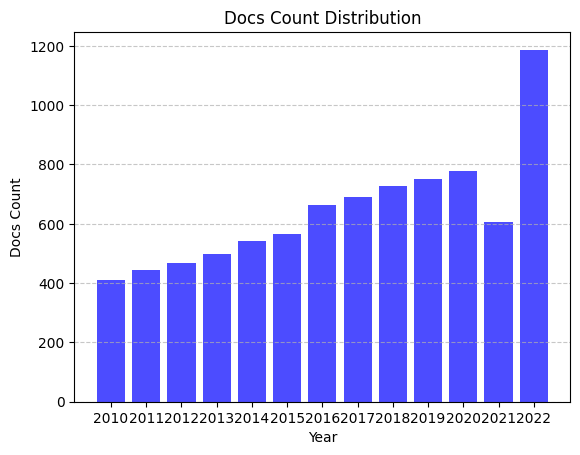

In [10]:
from sqlalchemy import func
import  matplotlib.pyplot as plt
import numpy as np

results = session.query(ddi.year, func.count().label('docs_count')).group_by(ddi.year).all()


# Extract age and user_count from the results
year, docs_count = zip(*[(result.year, result.docs_count) for result in results])

# Plot the histogram
plt.bar(year, docs_count, color='blue', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Docs Count')
plt.title('Docs Count Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()